<a href="https://colab.research.google.com/github/numoworld/learnpytorchio/blob/main/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

1.13.1+cu116


'cpu'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Increase complexity of a model. Model might not be able to learn mapping function because it doesn't have enough hidden layers or neurons.
2. Transfer learning. You can use model that is already well performing on a similar task and just tweak it to work on your problem.
3. Increase learning rate / train for longer. Model might not perform well because it doesn't converge to a local minimum.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
!rm -rf data/pizza_steak_sushi 

In [4]:
# 1. Get data
import requests
import zipfile
from pathlib import Path


data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print('Directory already exists.')
else:
    print('Creating directory...')
    image_path.mkdir(parents=True, exist_ok=True)

    with open(image_path / 'pizza_steak_sushi.zip', 'wb') as f:
        print('Downloading pizza_steak_sushi.zip...')
        response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(response.content)

    with zipfile.ZipFile(image_path / 'pizza_steak_sushi.zip', 'r') as f:
        print('Extracting data from pizza_steak_sushi.zip')
        f.extractall(image_path)

Creating directory...
Extracting data from pizza_steak_sushi.zip


In [5]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir('data/')

There are 1 directories and 0 images in 'data/'.
There are 2 directories and 1 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [6]:
# Setup train and testing paths

train_path = image_path / 'train'
test_path = image_path / 'test'

image_path_list = list(image_path.glob('*/*/*.jpg'))

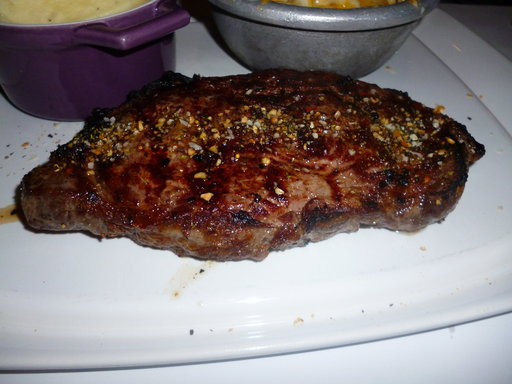

In [7]:
# Visualize an image
from PIL import Image
import random


random_image_path = random.choice(image_path_list)

img = Image.open(random_image_path)

img

(-0.5, 511.5, 383.5, -0.5)

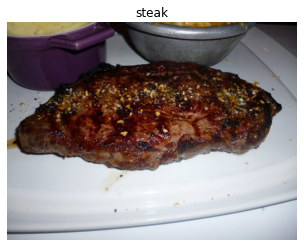

In [8]:
# Do the image visualization with matplotlib
import matplotlib.pyplot as plt
import numpy as np


img_arr = np.asarray(img)

plt.imshow(img_arr)
plt.title(random_image_path.parent.stem)
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [9]:
# 3.1 Transforming data with torchvision.transforms
from torchvision import transforms

In [10]:
# Write transform for turning images into tensors
train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

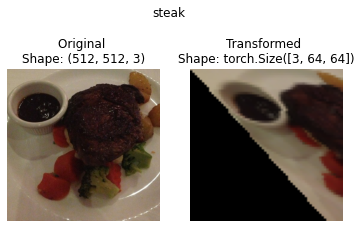

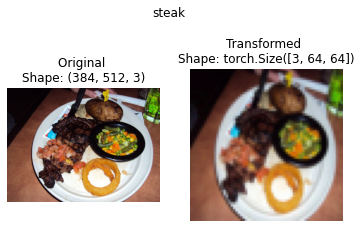

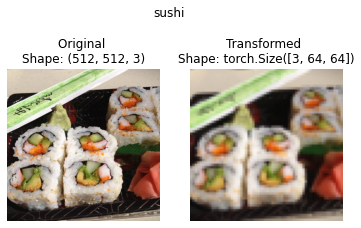

In [11]:
# Write a function to plot transformed images
def plot_transformed_images(
    image_path_list,
    transform,
    n=3
):
    """
    Selects n image paths form image_path_list and plots original image s
    and transformed with transform versions of an images

    Args:
        image_path_list: list of image paths from which to sample
        transform: transform to apply to images
        n: number of samples from image_path_list
    """
    random_image_paths = random.sample(
        image_path_list,
        k=n
    )

    for img_path in random_image_paths:
        
        with Image.open(img_path) as img:
            fig, ax = plt.subplots(1, 2)

            fig.suptitle(img_path.parent.stem)

            img_arr = np.asarray(img)
            ax[0].imshow(img_arr)
            ax[0].set_title(f'Original \nShape: {img_arr.shape}')
            ax[0].axis(False)

            t_img = transform(img)  
            ax[1].imshow(t_img.permute(1, 2, 0))  # CWH (PyTorch) -> WHC (Matplotlib)
            ax[1].set_title(f'Transformed \nShape: {t_img.shape}')
            ax[1].axis(False)

            plt.show()


plot_transformed_images(
    image_path_list,
    train_transform,
    3
)

### Load image data using `ImageFolder`

In [12]:
# Use ImageFolder to create dataset(s)
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


train_data = ImageFolder(
    train_path,
    train_transform
)

test_data = ImageFolder(
    test_path,
    test_transform
)

In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [16]:
# Turn train and test Datasets into DataLoaders

BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

train_dl = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dl = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

In [17]:
# How many batches of images are in our data loaders?
len(train_dl), len(test_dl)

(225, 75)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [21]:
class TinyVGG(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_units):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(3, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=out_shape)
        )
    def forward(self, x):
        return self.classifier(self.block_2(self.block_1(x)))
        

model_0 = TinyVGG(3, 3, 10)

try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    summary = torchinfo.summary(model_0, [1, 3, 64, 64]) 
summary   

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 4. Create training and testing functions for `model_0`.

In [28]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    logits = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(logits, y)
    train_loss += loss.item()
    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    pred = logits.argmax(dim=1)
    train_acc += (y == pred).sum().item() / len(y) 

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  
  return train_loss, train_acc

In [29]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      logits = model(X)

      # 2. Calculuate and accumulate loss
      test_loss += loss_fn(logits, y).item()

      # Calculate and accumulate accuracy
      pred = logits.argmax(dim=1)
      test_acc += (y == pred).sum().item() / len(y) 
    
    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
  
  return test_loss, test_acc

In [26]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [30]:
# Train for 5 epochs
torch.manual_seed(721)
torch.cuda.manual_seed(721)


model_1 = TinyVGG(3, 3, 10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=0.001)

results_5_epochs = train(
    model_1,
    train_dl,
    test_dl,
    optimizer,
    loss_fn,
    5
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1072 | train_acc: 0.2978 | test_loss: 1.0981 | test_acc: 0.4133
Epoch: 2 | train_loss: 1.1024 | train_acc: 0.3556 | test_loss: 1.0992 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.1030 | train_acc: 0.3333 | test_loss: 1.1003 | test_acc: 0.2533
Epoch: 4 | train_loss: 1.0993 | train_acc: 0.3333 | test_loss: 1.1002 | test_acc: 0.2533
Epoch: 5 | train_loss: 1.0996 | train_acc: 0.3156 | test_loss: 1.1004 | test_acc: 0.3333


In [31]:
# Train for 20 epochs
torch.manual_seed(721)
torch.cuda.manual_seed(721)


model_2 = TinyVGG(3, 3, 10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=0.001)

results_20_epochs = train(
    model_1,
    train_dl,
    test_dl,
    optimizer,
    loss_fn,
    20
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1072 | train_acc: 0.2978 | test_loss: 1.0981 | test_acc: 0.4133
Epoch: 2 | train_loss: 1.1024 | train_acc: 0.3556 | test_loss: 1.0992 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.1030 | train_acc: 0.3333 | test_loss: 1.1003 | test_acc: 0.2533
Epoch: 4 | train_loss: 1.0993 | train_acc: 0.3333 | test_loss: 1.1002 | test_acc: 0.2533
Epoch: 5 | train_loss: 1.0996 | train_acc: 0.3156 | test_loss: 1.1004 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.0990 | train_acc: 0.3200 | test_loss: 1.1002 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.0993 | train_acc: 0.3200 | test_loss: 1.1006 | test_acc: 0.2533
Epoch: 8 | train_loss: 1.0992 | train_acc: 0.3156 | test_loss: 1.1006 | test_acc: 0.2533
Epoch: 9 | train_loss: 1.0990 | train_acc: 0.3200 | test_loss: 1.1007 | test_acc: 0.3333
Epoch: 10 | train_loss: 1.0993 | train_acc: 0.3200 | test_loss: 1.1010 | test_acc: 0.3333
Epoch: 11 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1018 | test_acc: 0.3333
Epoch: 12 | train_l

In [32]:
# Train for 50 epochs
torch.manual_seed(721)
torch.cuda.manual_seed(721)


model_3 = TinyVGG(3, 3, 10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=0.001)

results_50_epochs = train(
    model_1,
    train_dl,
    test_dl,
    optimizer,
    loss_fn,
    50
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1072 | train_acc: 0.2978 | test_loss: 1.0981 | test_acc: 0.4133
Epoch: 2 | train_loss: 1.1024 | train_acc: 0.3556 | test_loss: 1.0992 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.1030 | train_acc: 0.3333 | test_loss: 1.1003 | test_acc: 0.2533
Epoch: 4 | train_loss: 1.0993 | train_acc: 0.3333 | test_loss: 1.1002 | test_acc: 0.2533
Epoch: 5 | train_loss: 1.0996 | train_acc: 0.3156 | test_loss: 1.1004 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.0990 | train_acc: 0.3200 | test_loss: 1.1002 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.0993 | train_acc: 0.3200 | test_loss: 1.1006 | test_acc: 0.2533
Epoch: 8 | train_loss: 1.0992 | train_acc: 0.3156 | test_loss: 1.1006 | test_acc: 0.2533
Epoch: 9 | train_loss: 1.0990 | train_acc: 0.3200 | test_loss: 1.1007 | test_acc: 0.3333
Epoch: 10 | train_loss: 1.0993 | train_acc: 0.3200 | test_loss: 1.1010 | test_acc: 0.3333
Epoch: 11 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1018 | test_acc: 0.3333
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [33]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(721)
torch.cuda.manual_seed(721)


model_4 = TinyVGG(3, 3, 20).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=0.001)

results_20_epochs = train(
    model_1,
    train_dl,
    test_dl,
    optimizer,
    loss_fn,
    20
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1028 | train_acc: 0.3111 | test_loss: 1.1013 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.0989 | train_acc: 0.2889 | test_loss: 1.1017 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0990 | train_acc: 0.3378 | test_loss: 1.1017 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0989 | train_acc: 0.3467 | test_loss: 1.1015 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.5134 | train_acc: 0.3733 | test_loss: 1.1129 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.1003 | train_acc: 0.3156 | test_loss: 1.1008 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1017 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1012 | test_acc: 0.3333
Epoch: 9 | train_loss: 1.0986 | train_acc: 0.3467 | test_loss: 1.1014 | test_acc: 0.3333
Epoch: 10 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1015 | test_acc: 0.3333
Epoch: 11 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1016 | test_acc: 0.3333
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [34]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [35]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.


Excellent, we now have double the training and testing images... 

In [36]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [47]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.TrivialAugmentWide(),                                     
  transforms.ToTensor()
])

# Create datasets
train_data = ImageFolder(
    train_data_20_percent_path,
    transform=simple_transform
)
test_data = ImageFolder(
    test_data_20_percent_path,
    transform=simple_transform
)

# Create dataloaders
train_dl = DataLoader(
    train_data,
    batch_size=64,
    num_workers=NUM_WORKERS,
    shuffle=True
)
test_dl = DataLoader(
    test_data,
    batch_size=64,
    num_workers=NUM_WORKERS
)

In [48]:
# Train a model with increased amount of data
torch.manual_seed(721)
torch.cuda.manual_seed(721)


model_5 = TinyVGG(3, 3, 20).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_5.parameters(), 
                             lr=0.001)

results_20_epochs = train(
    model_5,
    train_dl,
    test_dl,
    optimizer,
    loss_fn,
    20
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1015 | train_acc: 0.2812 | test_loss: 1.0975 | test_acc: 0.2595
Epoch: 2 | train_loss: 1.0959 | train_acc: 0.3613 | test_loss: 1.1014 | test_acc: 0.2396
Epoch: 3 | train_loss: 1.0890 | train_acc: 0.3613 | test_loss: 1.0907 | test_acc: 0.2391
Epoch: 4 | train_loss: 1.0977 | train_acc: 0.3008 | test_loss: 1.0591 | test_acc: 0.4995
Epoch: 5 | train_loss: 1.0666 | train_acc: 0.4414 | test_loss: 1.0783 | test_acc: 0.4048
Epoch: 6 | train_loss: 1.0114 | train_acc: 0.4629 | test_loss: 0.9790 | test_acc: 0.4943
Epoch: 7 | train_loss: 1.0324 | train_acc: 0.4238 | test_loss: 1.0030 | test_acc: 0.5365
Epoch: 8 | train_loss: 0.9526 | train_acc: 0.5039 | test_loss: 0.9927 | test_acc: 0.4891
Epoch: 9 | train_loss: 0.9357 | train_acc: 0.5840 | test_loss: 1.0862 | test_acc: 0.4110
Epoch: 10 | train_loss: 0.9492 | train_acc: 0.5078 | test_loss: 1.0150 | test_acc: 0.4545
Epoch: 11 | train_loss: 0.9122 | train_acc: 0.5137 | test_loss: 1.0530 | test_acc: 0.3632
Epoch: 12 | train_l

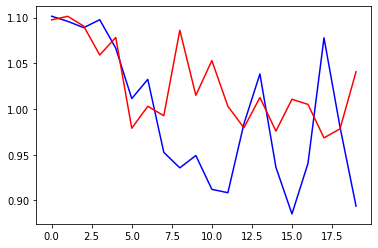

In [52]:
plt.plot(results_20_epochs['train_loss'], c='b', label='train loss')
plt.plot(results_20_epochs['test_loss'], c='r', label='test loss')

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

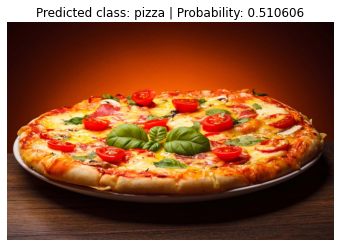

In [78]:
import io
import torchvision

def predict_image_class_from_url(
    url,
    model,
    transform,
    class_names
):
  with open('custom.jpg', 'wb') as buffer:
    response = requests.get(url)
    buffer.write(response.content)
    
  img = Image.open('custom.jpg')
  img_tensor = transform(img).type(torch.float32) 

  model.eval() 

  logits = model(img_tensor.to(device).unsqueeze(0))

  pred_label = logits.argmax(dim=1).item()
  pred_proba = torch.softmax(logits, dim=1)[0][pred_label].item()
  class_name = class_names[pred_label]

  plt.imshow(img)
  plt.title(f'Predicted class: {class_name} | Probability: {pred_proba:2f}')
  plt.axis('off')


URL = 'https://cdn.britannica.com/08/177308-050-94D9D6BE/Food-Pizza-Basil-Tomato.jpg'

predict_image_class_from_url(
    URL,
    model_5,
    simple_transform,
    class_names=train_dl.dataset.classes
)